In [1]:
import pandas as pd
import numpy as np
import itertools
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import scipy.stats
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from hyperopt.pyll.base import scope
import seaborn as sns
from matplotlib import cm, pyplot as plt
from scipy import stats as st
from sklearn.utils import resample

sns.set()

## Read multiple csv files into selected format

In [2]:
def load_data(asset, level):
    data = pd.read_csv('./data/order_books_data_archive/{0}_2012-06-21_34200000_57600000_orderbook_{1}.csv'.format(asset, level), header=None)
    
    levels = list(range(1, level + 1))
    iters = [iter(levels), iter(levels), iter(levels), iter(levels)]
    abv = ['ask', 'volume_ask', 'bid', 'volume_bid'] * level
    nums = [x for x in itertools.chain.from_iterable(itertools.zip_longest(levels, levels, levels, levels)) if x]
    data.columns = list(map(lambda x, y: '{0}_{1}'.format(x, y), abv, nums))
    
    return data

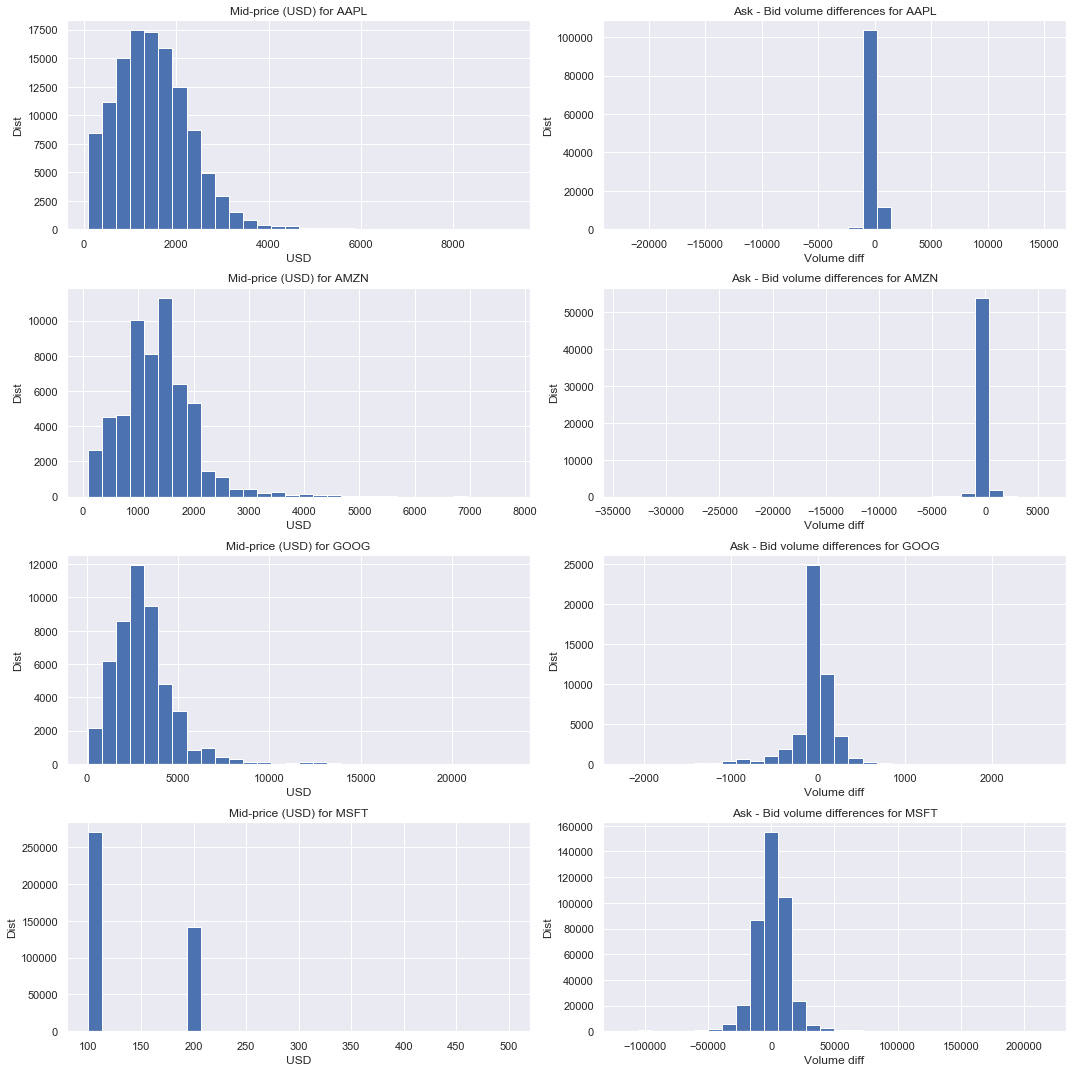

In [3]:
assets = ['AAPL', 'AMZN', 'GOOG', 'MSFT']
fig, axs = plt.subplots(len(assets), 2, figsize = (15, 15))
colours = cm.prism(np.linspace(0, 1, len(assets)))

for i, (ax, colour) in enumerate(zip(axs, colours)):
    asset = assets[i]
    source_data = load_data(asset, 1)
    diff_volumes = source_data.volume_ask_1 - source_data.volume_bid_1
    mid_price = source_data.ask_1 - source_data.bid_1
    
    ax[0].hist(mid_price[~np.isnan(mid_price)], bins = 30)
    ax[0].set_title('Mid-price (USD) for ' + asset)
    ax[0].set_xlabel('USD')
    ax[0].set_ylabel('Dist')
    
    ax[1].hist(diff_volumes[~np.isnan(diff_volumes)], bins = 30)
    ax[1].set_title('Ask - Bid volume differences for ' + asset)
    ax[1].set_xlabel('Volume diff')
    ax[1].set_ylabel('Dist')
    
plt.tight_layout()

## Feature Engineering ~ logrithmic relationships btwn different depths of data

In [4]:
def feature_engineering(ds, level, num_lags):
    out_ds = pd.DataFrame()
    
    for i in range(1, level + 1):
        out_ds['log_return_ask_{0}'.format(i)] = np.log(ds['ask_{0}'.format(i)].pct_change() + 1)
        out_ds['log_return_bid_{0}'.format(i)] = np.log(ds['bid_{0}'.format(i)].pct_change() + 1)
        
        out_ds['log_ask_{0}_div_bid_{0}'.format(i)] = np.log(ds['ask_{0}'.format(i)] / ds['bid_{0}'.format(i)])
        out_ds['log_volume_ask_{0}_div_bid_{0}'.format(i)] = np.log(ds['volume_ask_{0}'.format(i)] / ds['volume_bid_{0}'.format(i)])
        
        out_ds['log_volume_ask_{0}'.format(i)] = np.log(ds['volume_ask_{0}'.format(i)])
        out_ds['log_volume_bid_{0}'.format(i)] = np.log(ds['volume_bid_{0}'.format(i)])
        
        if i != 1:
            out_ds['log_ask_{0}_div_ask_1'.format(i)] = np.log(ds['ask_{0}'.format(i)] / ds['ask_1'])
            out_ds['log_bid_{0}_div_bid_1'.format(i)] = np.log(ds['bid_{0}'.format(i)] / ds['bid_1'])
            out_ds['log_volume_ask_{0}_div_ask_1'.format(i)] = np.log(ds['volume_ask_{0}'.format(i)] / ds['volume_ask_1'])
            out_ds['log_volume_bid_{0}_div_bid_1'.format(i)] = np.log(ds['volume_bid_{0}'.format(i)] / ds['volume_bid_1'])
        
    out_ds['log_total_volume_ask'] = np.log(ds[['volume_ask_{0}'.format(x) for x in list(range(1, level + 1))]].sum(axis = 1))
    out_ds['log_total_volume_bid'] = np.log(ds[['volume_bid_{0}'.format(x) for x in list(range(1, level + 1))]].sum(axis = 1))
            
    mid_price = (ds['ask_1'] + ds['bid_1']) / 2
    out_ds['log_return_mid_price'] = np.log(mid_price.pct_change() + 1).shift(-1)
        
    cols_features = out_ds.columns.drop(target_column)
    out_ds = out_ds.assign(**{
        '{}_(t-{})'.format(col, t): out_ds[col].shift(t)
        for t in list(range(1, num_lags))
        for col in cols_features})
    
    return out_ds.dropna()

In [5]:
target_column = 'log_return_mid_price'

## Test load_data & feature_engineering functions

In [6]:
source_data = load_data('AAPL', 1)
dataset = feature_engineering(source_data, 1, 1)

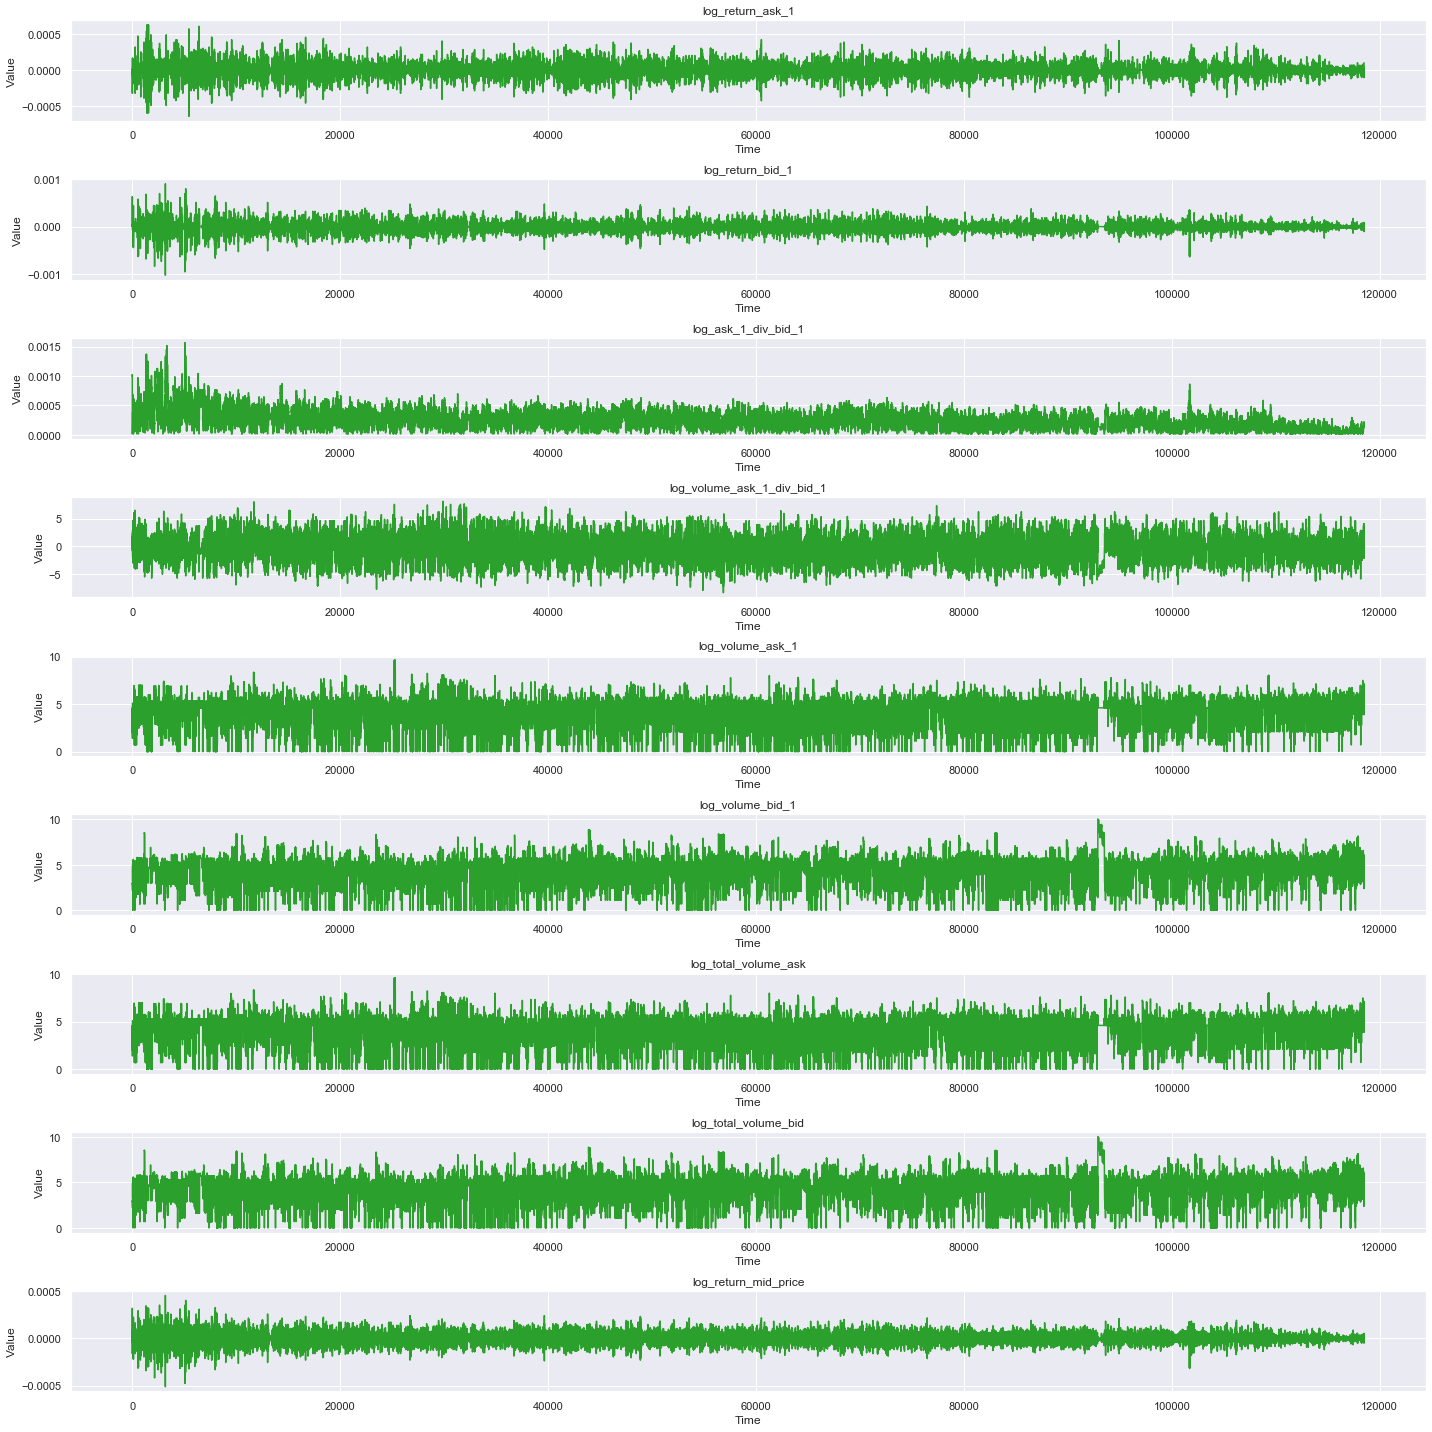

In [7]:
fig, axs = plt.subplots(len(dataset.columns), 1, figsize = (20, 20))
for i in range(0, len(dataset.columns)):
    c = dataset.columns[i]
    
    axs[i].plot(dataset[c],'tab:green')
    axs[i].set_title(c)
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Value')
plt.tight_layout()
plt.show()

## Bootstrapping, Hyperopt, Train/Valid/Test

In [8]:
def bs_interval(arr, num_bs_size = 10000, num_elements_mean = 1000, alpha = 0.05):
    bs = list()
    for i in range(0, num_bs_size):
        bs.append(np.mean(resample(arr, n_samples = num_elements_mean)))
        
    return st.t.interval(1 - alpha, len(bs) - 1, loc = np.mean(bs), scale = st.sem(bs))

def objective(hyper_params):
    print(hyper_params)
    
    source_data = load_data(hyper_params['asset_name'], hyper_params['level'])
    dataset = feature_engineering(source_data, hyper_params['level'], int(hyper_params['num_lags']))
    
    start_valid_ind = int(dataset.shape[0] * 0.5)
    start_test_ind = int(dataset.shape[0] * 0.75)
    train_ds = dataset[:start_valid_ind]
    valid_ds = dataset[start_valid_ind:start_test_ind]
    
    regr = CatBoostRegressor(n_estimators = hyper_params['n_estimators'], thread_count=3, task_type = 'CPU',
                             learning_rate = hyper_params['learning_rate'], depth = hyper_params['depth'],
                             l2_leaf_reg = hyper_params['l2_leaf_reg'], loss_function = 'RMSE')
    
    regr.fit(train_ds[train_ds.columns.drop(target_column)], train_ds[target_column],
             use_best_model = True, logging_level = 'Silent',
             eval_set = (valid_ds[valid_ds.columns.drop(target_column)], valid_ds[target_column]))

    predictions = regr.predict(valid_ds[valid_ds.columns.drop(target_column)])
    result = mean_squared_error(valid_ds[target_column], predictions)
    
    print('Objective function value on validation set: ' + str(result))
    return result

def run_experiment(asset_name):
    levels = [1, 5, 10]
    const_params = {'ticker_symbol': asset_name}
    hyper_params_space = {'level': hp.choice('level', levels),
                          'num_lags': hp.quniform('num_lags', 1, 10, 1),
                          'n_estimators': hp.quniform('n_estimators', 50, 500, 5),
                          'depth': hp.quniform('depth', 1, 10, 1),
                          'learning_rate': hp.uniform('learning_rate', 0.05, 1.0),
                          'l2_leaf_reg':  hp.uniform('l2_leaf_reg', 0.01, 20.0)}
    
    hyper_params_space.update(const_params)
    
    tpe_trials = Trials()
    opt_params = fmin(
        fn = objective,
        space = hyper_params_space,
        algo = tpe.suggest,
        max_evals = 20,
        trials = tpe_trials,
        rstate = np.random.RandomState(100))
    
    opt_params.update(const_params)
    opt_params['level'] = levels[opt_params['level']]
    print('Key parameters:')
    print(opt_params)
    
    source_data = load_data(asset_name, opt_params['level'])
    print('Input data shape is {0}'.format(source_data.shape))
    print(source_data.head())
    
    dataset = feature_engineering(source_data, opt_params['level'], int(opt_params['num_lags']))
    print('Dataset shape is {0}'.format(dataset.shape))
    print(dataset.head())
    
    '''
    for c in dataset.columns:
        plt.figure(figsize=(15, 10))
        plt.plot(dataset[c])
        plt.title(c)
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.show()
    '''
    start_test_ind = int(dataset.shape[0] * 0.75)
    train_ds = dataset[:start_test_ind]
    test_ds = dataset[start_test_ind:]
    
    regr = CatBoostRegressor(n_estimators = opt_params['n_estimators'], thread_count=3, task_type = 'CPU',
                             learning_rate = opt_params['learning_rate'], depth = opt_params['depth'],
                             l2_leaf_reg = opt_params['l2_leaf_reg'], loss_function = 'RMSE')
    
    regr.fit(train_ds[train_ds.columns.drop(target_column)], train_ds[target_column],
         use_best_model = False, logging_level = 'Silent')
    
    fi = pd.DataFrame({'feature': regr.feature_names_, 'importance': regr.feature_importances_})
    plt.figure(figsize=(30, 30))
    plt.barh(fi.feature, fi.importance)
    plt.title('Key Features')
    plt.show()

    print('Key Features Table:')
    print(fi.sort_values('importance', ascending = False))
    
    predictions = regr.predict(test_ds[test_ds.columns.drop(target_column)])
    baseline_mse = np.array((test_ds[target_column] - np.zeros_like(test_ds[target_column])) ** 2)
    modeling_mse = np.array((test_ds[target_column] - predictions) ** 2)
    
    print('MSE on test set: ' + str(mean_squared_error(test_ds[target_column], predictions)))
    print('Confidence interval of baseline MSE: ' + str(bs_interval(baseline_mse)))
    print('Confidence interval of modeling MSE: ' + str(bs_interval(modeling_mse)))
    
    plt.figure(figsize=(30, 30))
    plt.scatter(test_ds[target_column], predictions)
    plt.title('True returns & Predictions scatter plot')
    plt.xlabel('True returns')
    plt.ylabel('Predictions')
    plt.show()

{'asset_name': 'AAPL', 'depth': 8.0, 'l2_leaf_reg': 6.375518633702504, 'learning_rate': 0.820242773021529, 'level': 5, 'n_estimators': 160.0, 'num_lags': 4.0}
Objective function value on validation set: 2.7676447464167856e-10
{'asset_name': 'AAPL', 'depth': 3.0, 'l2_leaf_reg': 18.570831106598128, 'learning_rate': 0.16893633551130577, 'level': 10, 'n_estimators': 125.0, 'num_lags': 5.0}
Objective function value on validation set: 1.9749086814754247e-10                  
{'asset_name': 'AAPL', 'depth': 6.0, 'l2_leaf_reg': 16.005277983088614, 'learning_rate': 0.3643657415946367, 'level': 5, 'n_estimators': 235.0, 'num_lags': 4.0}
Objective function value on validation set: 2.7101105256563385e-10                  
{'asset_name': 'AAPL', 'depth': 2.0, 'l2_leaf_reg': 8.096031755725166, 'learning_rate': 0.2046503426057844, 'level': 10, 'n_estimators': 295.0, 'num_lags': 5.0}
Objective function value on validation set: 1.9746621541826805e-10                  
{'asset_name': 'AAPL', 'depth': 5.

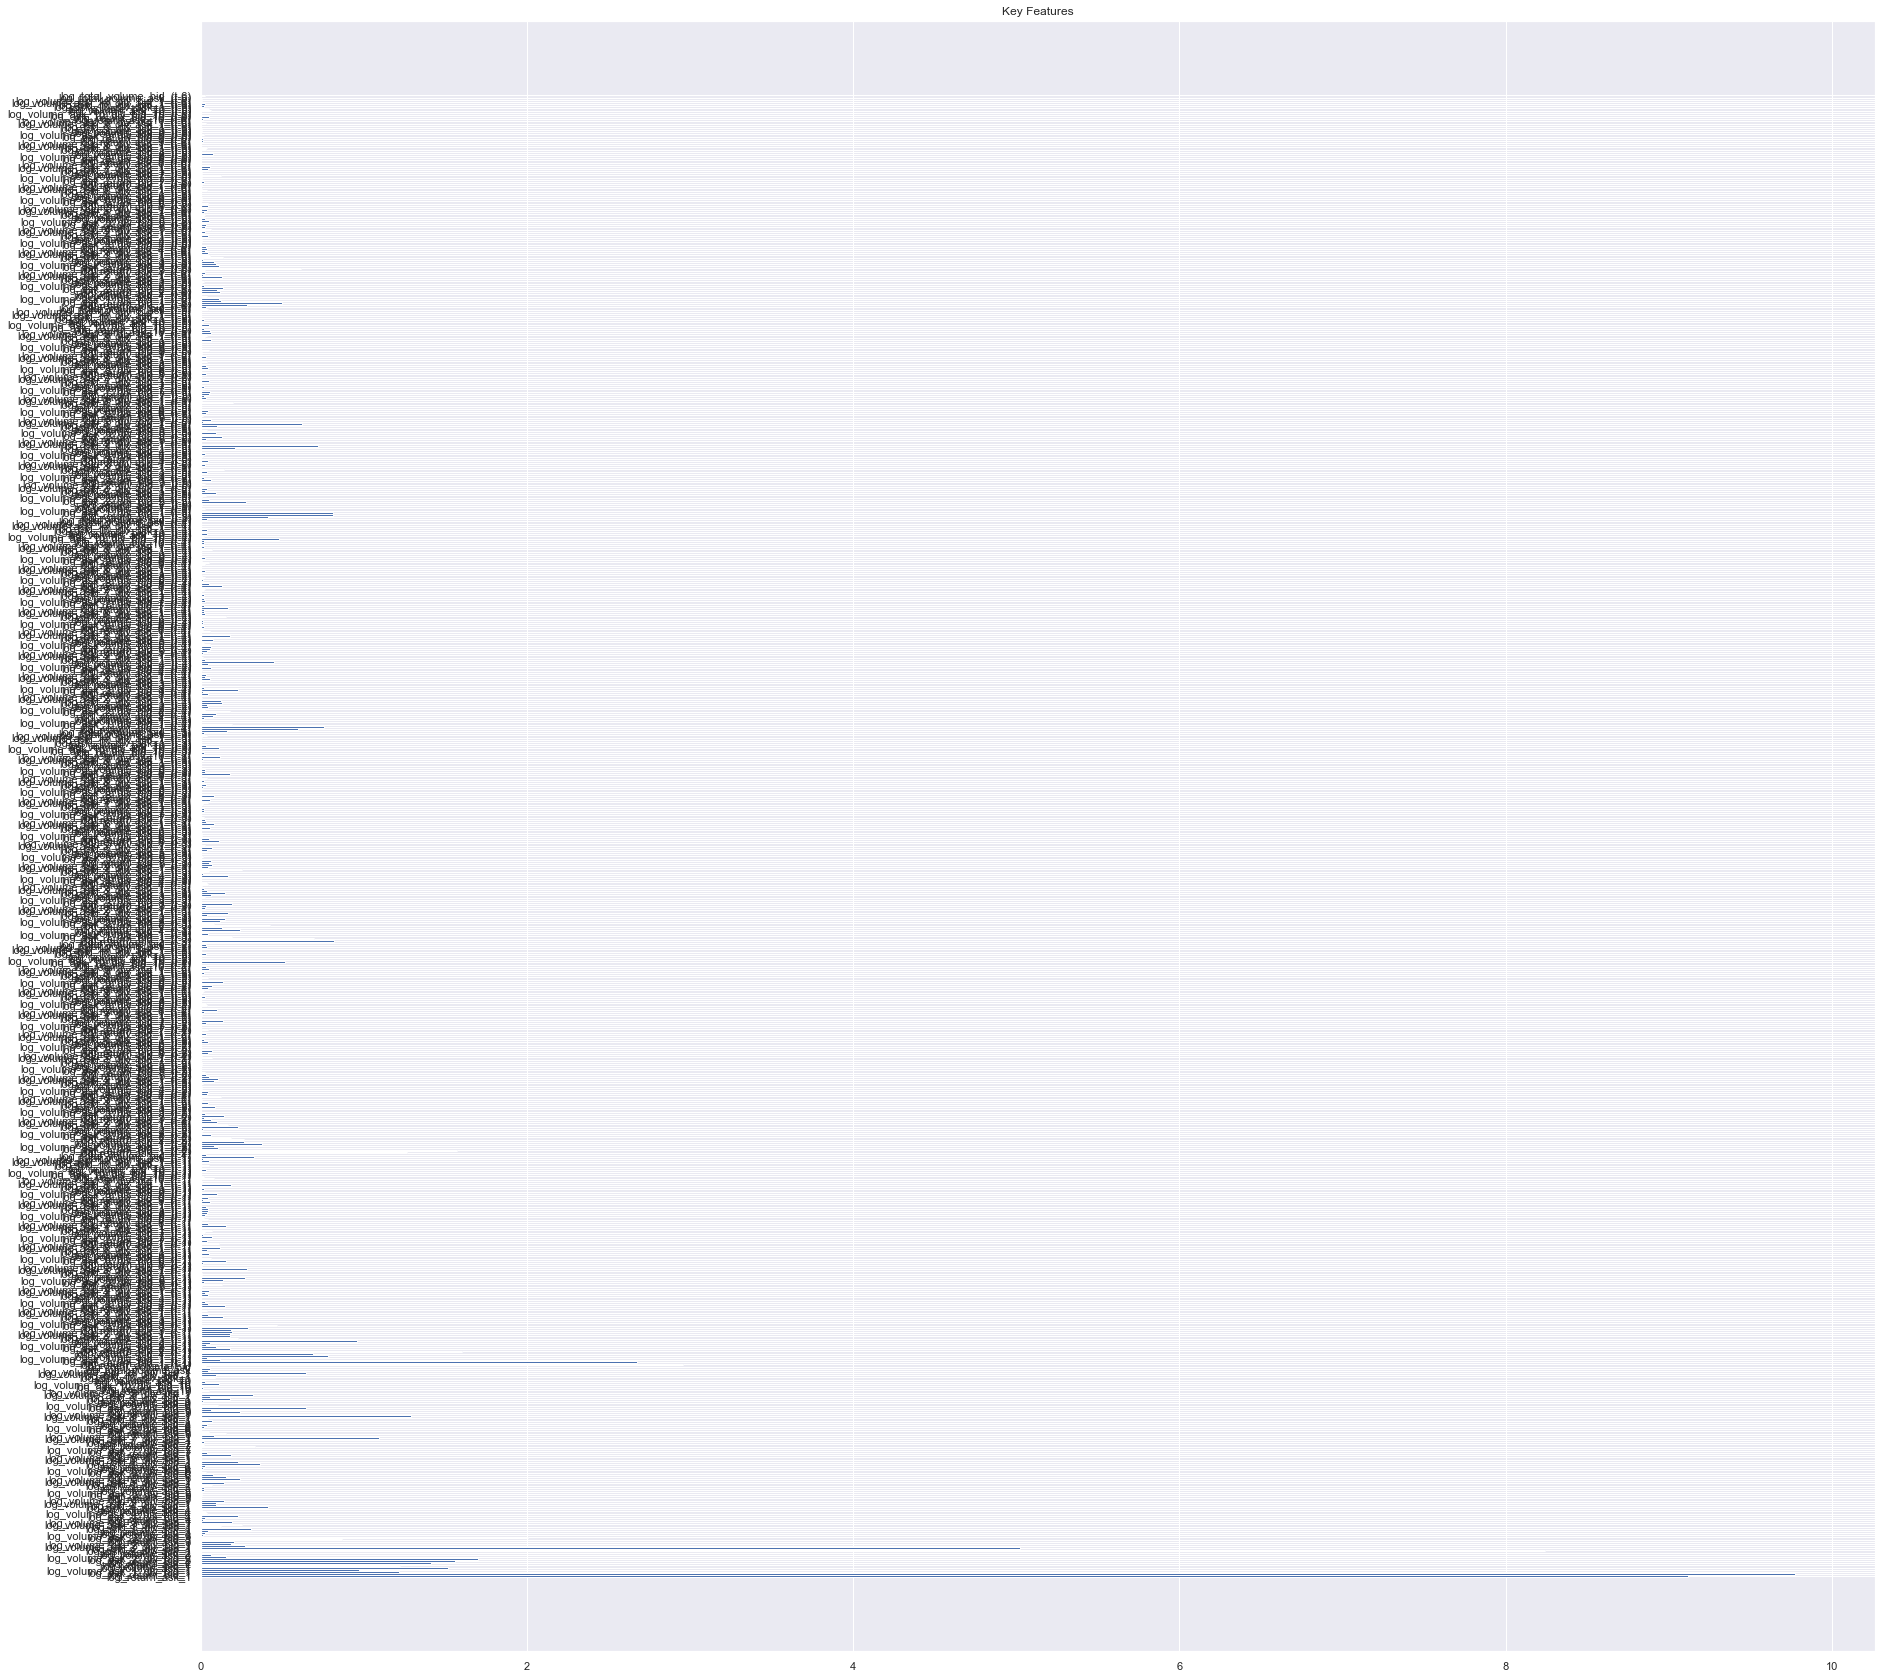

Key Features Table:
                              feature  importance
1                    log_return_bid_1    9.775394
0                    log_return_ask_1    9.120578
12                log_ask_2_div_ask_1    8.243142
13                log_bid_2_div_bid_1    5.021442
98             log_return_ask_1_(t-1)    2.954718
..                                ...         ...
218         log_ask_3_div_ask_1_(t-2)    0.000000
216            log_volume_ask_3_(t-2)    0.000000
504  log_volume_ask_2_div_ask_1_(t-5)    0.000000
215  log_volume_ask_3_div_bid_3_(t-2)    0.000000
517            log_return_bid_4_(t-5)    0.000000

[686 rows x 2 columns]
MSE on test set: 1.642452385506241e-10
Confidence interval of baseline MSE: (1.8079715721352604e-10, 1.8234349767245142e-10)
Confidence interval of modeling MSE: (1.6311998430092962e-10, 1.6440158406034105e-10)


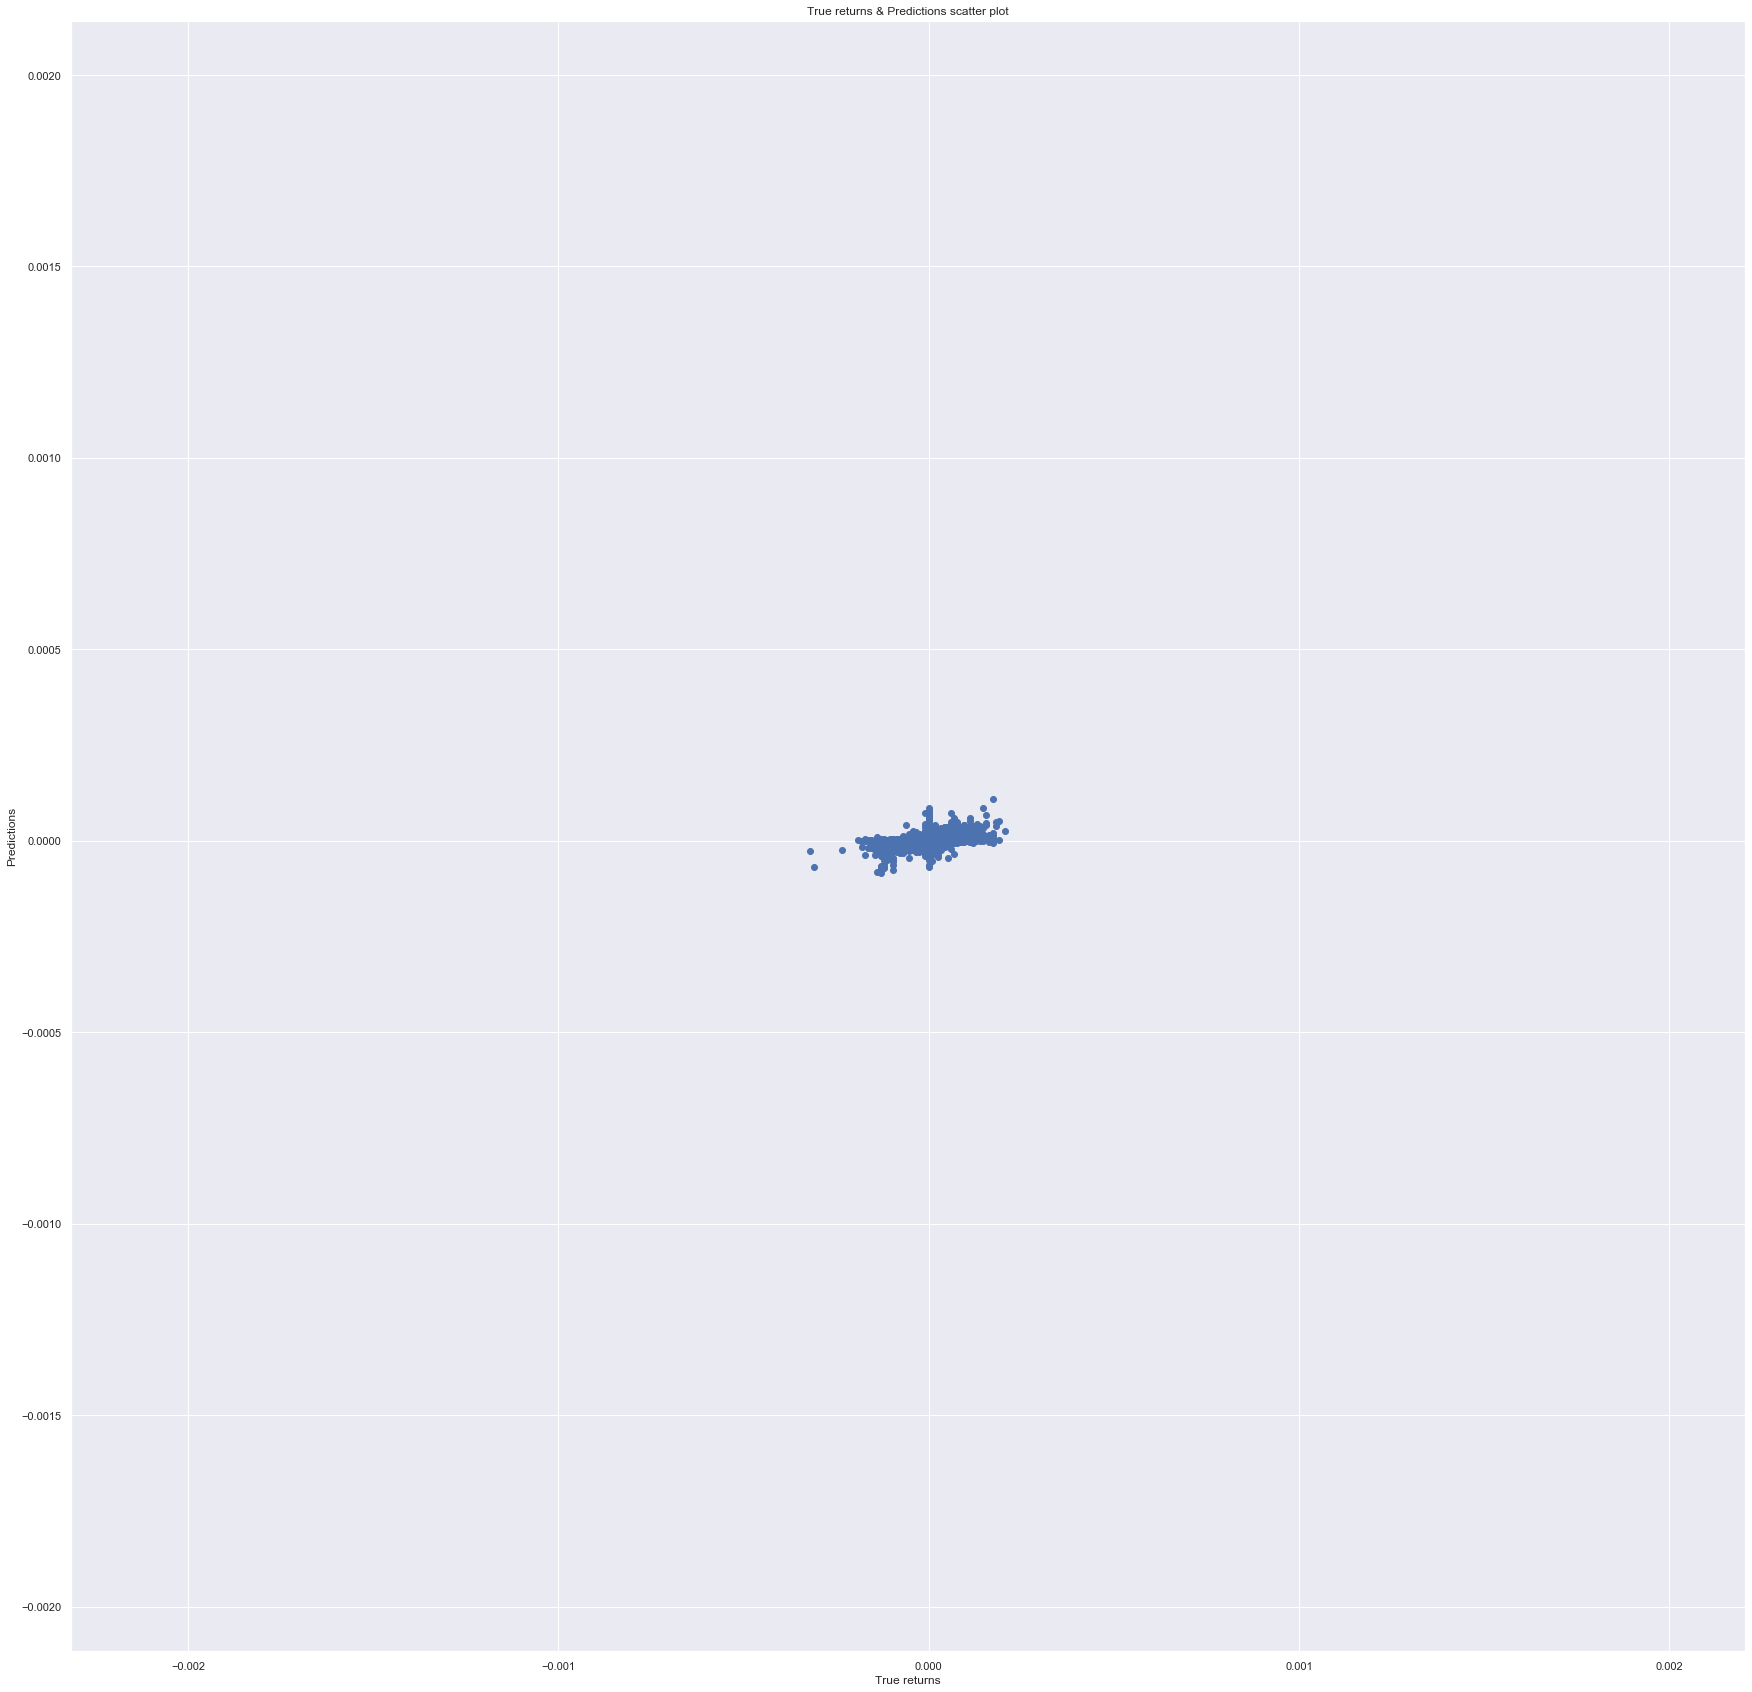

In [9]:
run_experiment('AAPL')

{'asset_name': 'AMZN', 'depth': 8.0, 'l2_leaf_reg': 6.375518633702504, 'learning_rate': 0.820242773021529, 'level': 5, 'n_estimators': 160.0, 'num_lags': 4.0}
Objective function value on validation set: 1.022934225369716e-09
{'asset_name': 'AMZN', 'depth': 3.0, 'l2_leaf_reg': 18.570831106598128, 'learning_rate': 0.16893633551130577, 'level': 10, 'n_estimators': 125.0, 'num_lags': 5.0}
Objective function value on validation set: 5.385559376798866e-10                  
{'asset_name': 'AMZN', 'depth': 6.0, 'l2_leaf_reg': 16.005277983088614, 'learning_rate': 0.3643657415946367, 'level': 5, 'n_estimators': 235.0, 'num_lags': 4.0}
Objective function value on validation set: 1.001676236332166e-09                  
{'asset_name': 'AMZN', 'depth': 2.0, 'l2_leaf_reg': 8.096031755725166, 'learning_rate': 0.2046503426057844, 'level': 10, 'n_estimators': 295.0, 'num_lags': 5.0}
Objective function value on validation set: 5.368956271942004e-10                  
{'asset_name': 'AMZN', 'depth': 5.0, '

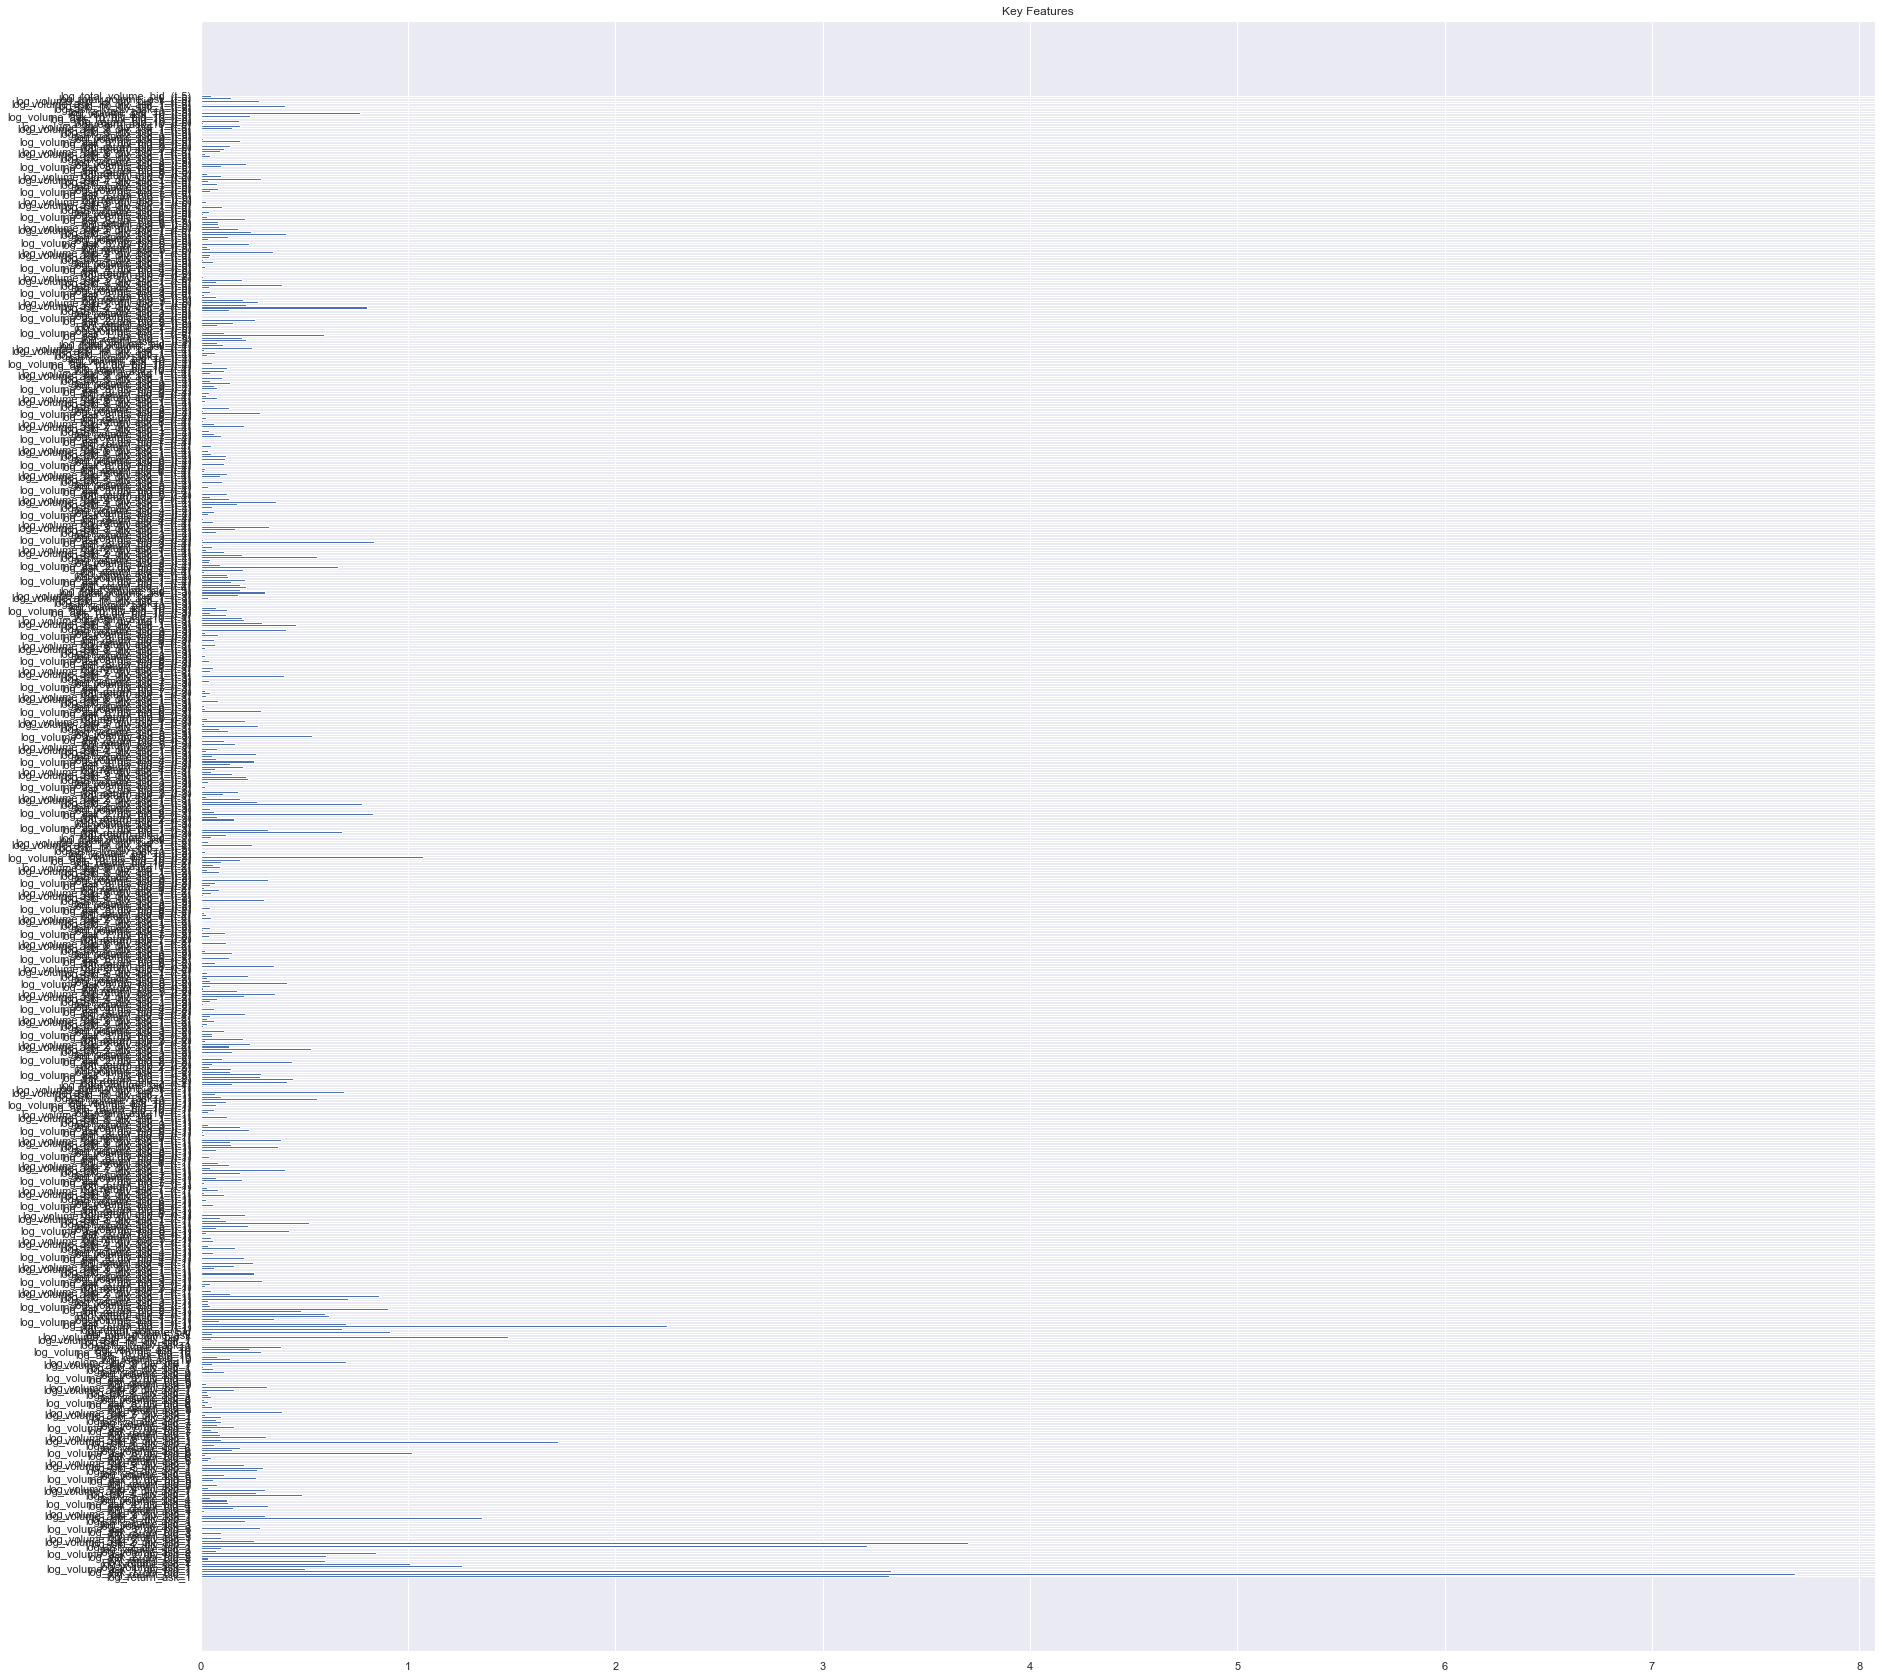

Key Features Table:
                       feature  importance
1             log_return_bid_1    7.690419
13         log_bid_2_div_bid_1    3.701546
2          log_ask_1_div_bid_1    3.328563
0             log_return_ask_1    3.318044
12         log_ask_2_div_ask_1    3.211291
..                         ...         ...
92        log_ask_10_div_ask_1    0.000000
88       log_ask_10_div_bid_10    0.000000
277     log_volume_bid_9_(t-2)    0.000000
269  log_bid_8_div_bid_1_(t-2)    0.000000
314     log_volume_ask_3_(t-3)    0.000000

[588 rows x 2 columns]
MSE on test set: 5.102585595803305e-10
Confidence interval of baseline MSE: (5.339981452194174e-10, 5.40028480045099e-10)
Confidence interval of modeling MSE: (5.093149899197213e-10, 5.148871356440227e-10)


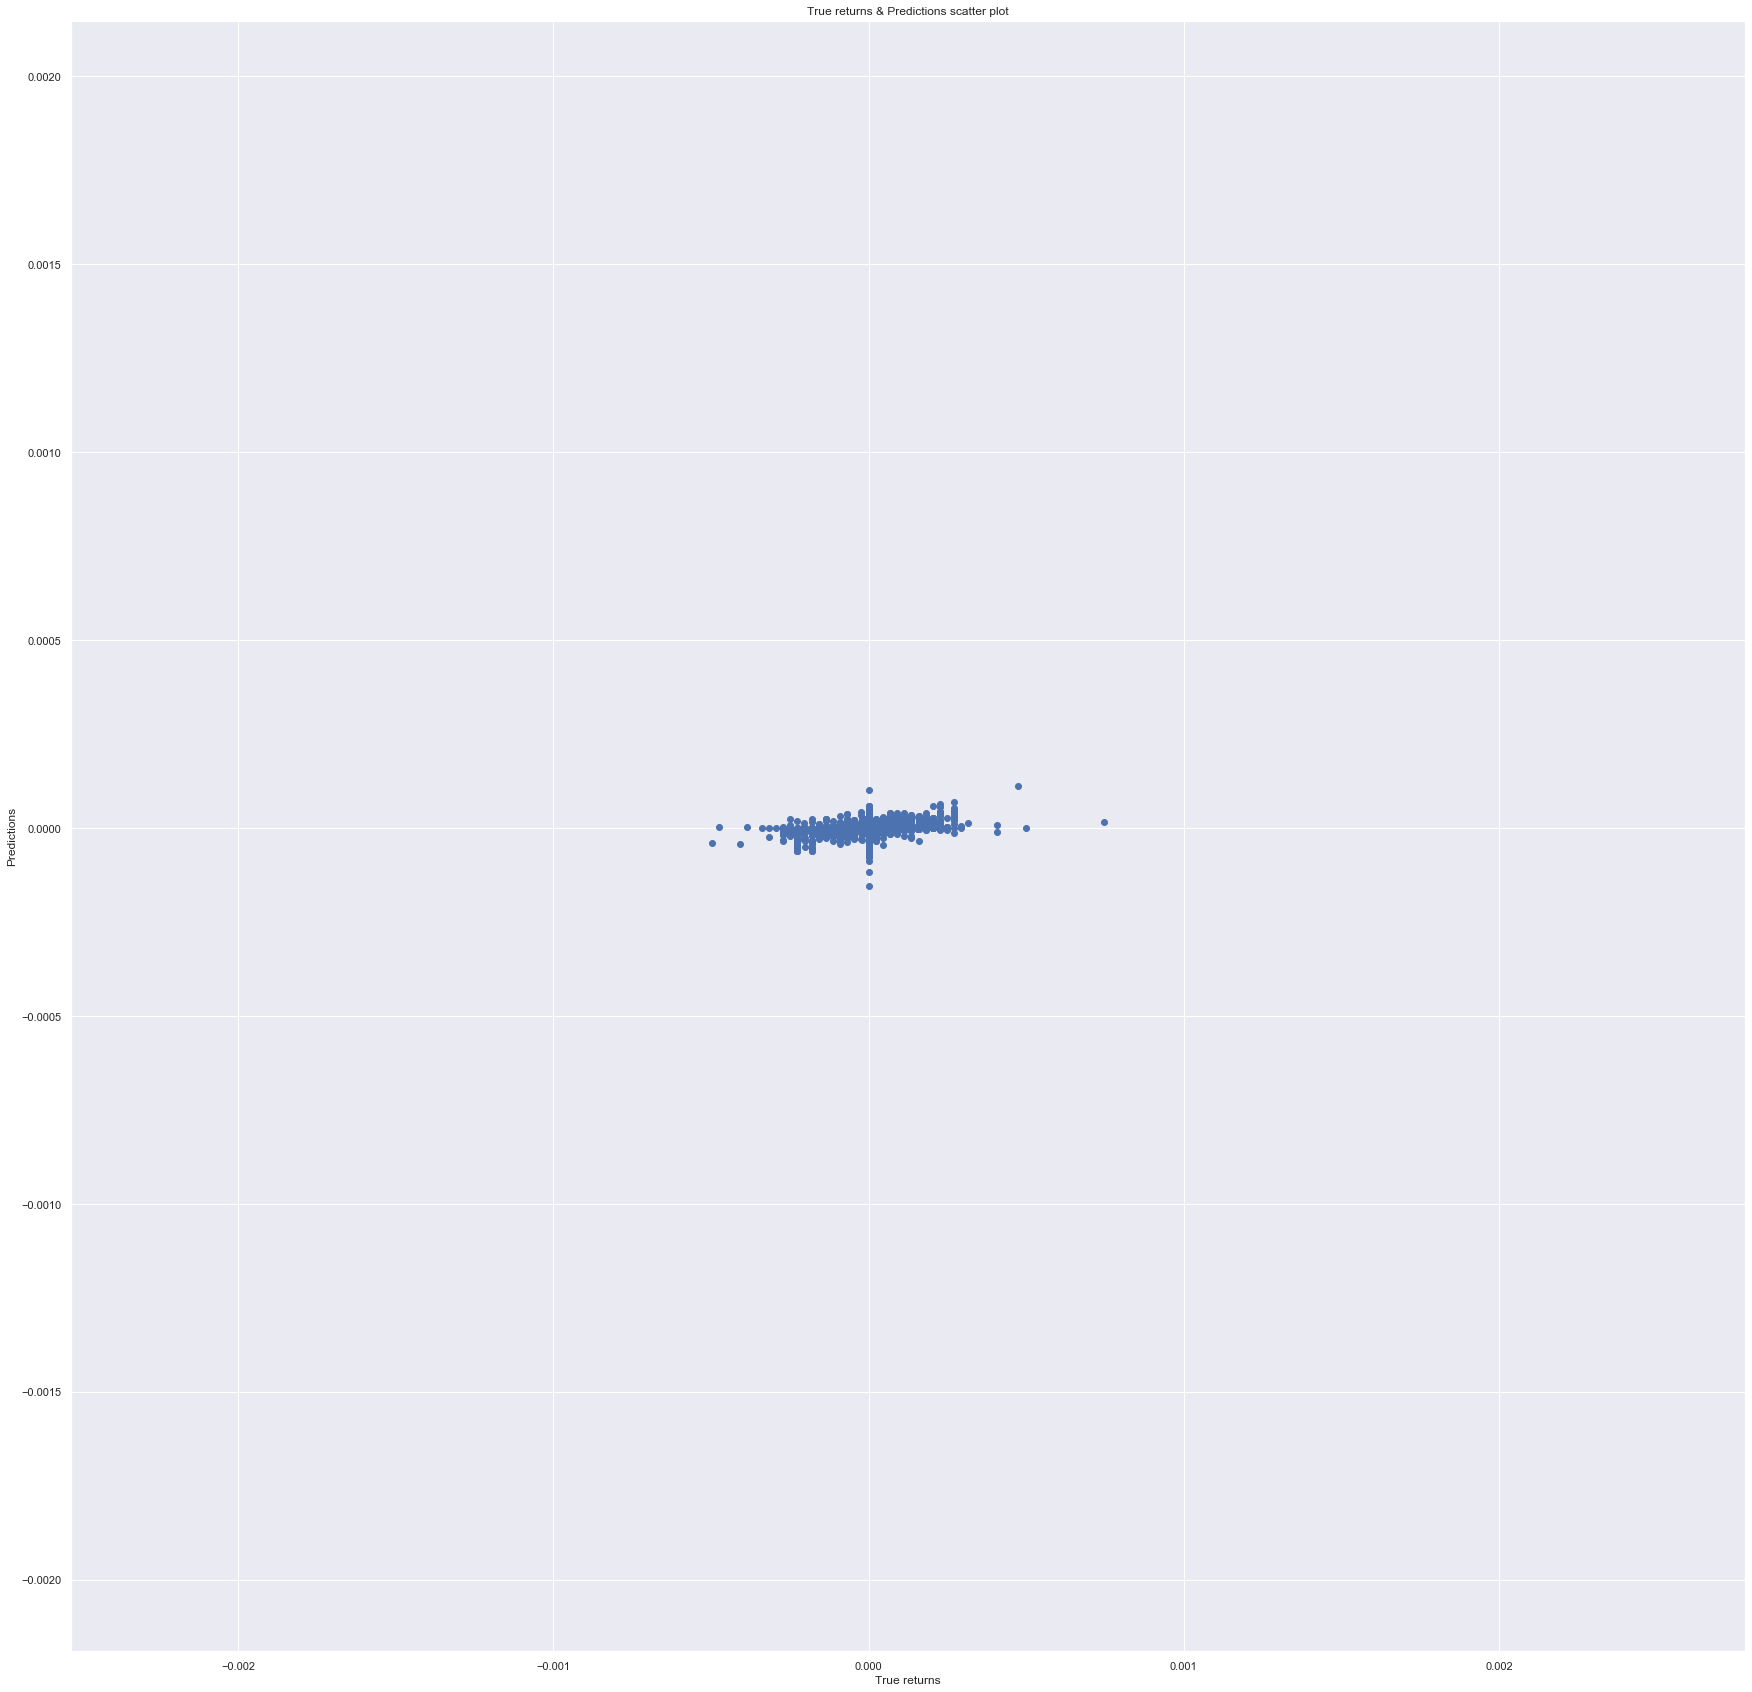

In [10]:
run_experiment('AMZN')

{'asset_name': 'GOOG', 'depth': 8.0, 'l2_leaf_reg': 6.375518633702504, 'learning_rate': 0.820242773021529, 'level': 5, 'n_estimators': 160.0, 'num_lags': 4.0}
Objective function value on validation set: 7.999104581290481e-10
{'asset_name': 'GOOG', 'depth': 3.0, 'l2_leaf_reg': 18.570831106598128, 'learning_rate': 0.16893633551130577, 'level': 10, 'n_estimators': 125.0, 'num_lags': 5.0}
Objective function value on validation set: 5.959886996817927e-10                  
{'asset_name': 'GOOG', 'depth': 6.0, 'l2_leaf_reg': 16.005277983088614, 'learning_rate': 0.3643657415946367, 'level': 5, 'n_estimators': 235.0, 'num_lags': 4.0}
Objective function value on validation set: 7.825984747992768e-10                  
{'asset_name': 'GOOG', 'depth': 2.0, 'l2_leaf_reg': 8.096031755725166, 'learning_rate': 0.2046503426057844, 'level': 10, 'n_estimators': 295.0, 'num_lags': 5.0}
Objective function value on validation set: 5.965318817206277e-10                  
{'asset_name': 'GOOG', 'depth': 5.0, '

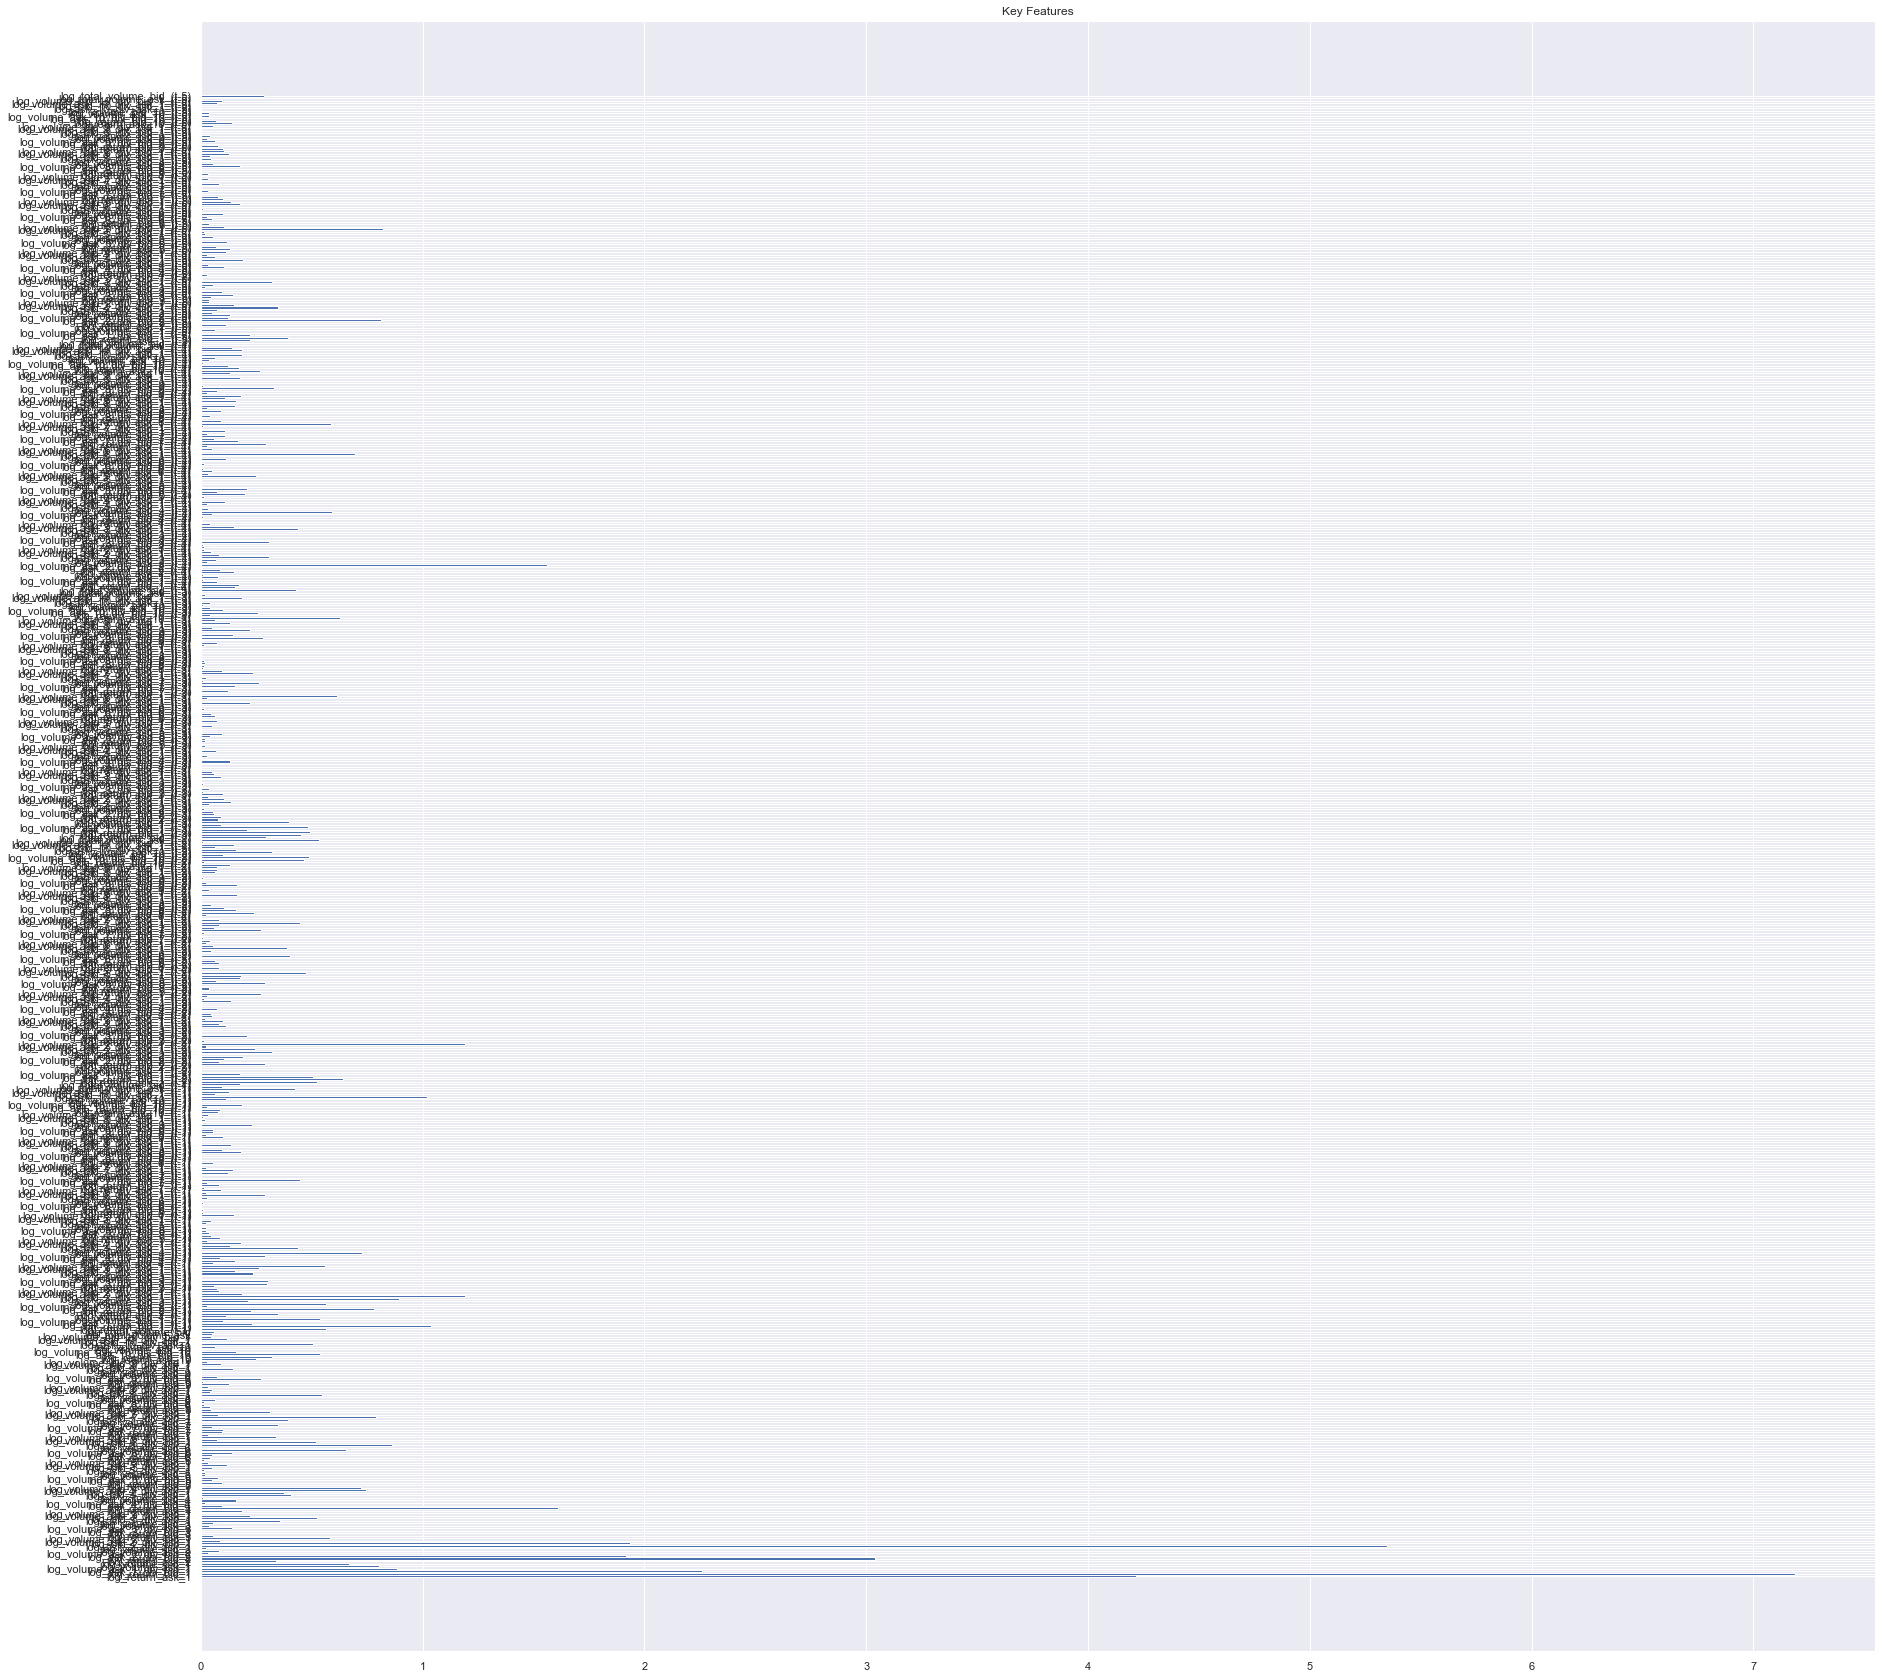

Key Features Table:
                              feature  importance
1                    log_return_bid_1    7.187992
12                log_ask_2_div_ask_1    5.349863
0                    log_return_ask_1    4.216894
7                    log_return_bid_2    3.040469
2                 log_ask_1_div_bid_1    2.261310
..                                ...         ...
180         log_ask_9_div_ask_1_(t-1)    0.000000
178            log_volume_ask_9_(t-1)    0.000000
465         log_bid_8_div_bid_1_(t-4)    0.000000
173  log_volume_bid_8_div_bid_1_(t-1)    0.000000
51                   log_volume_bid_6    0.000000

[588 rows x 2 columns]
MSE on test set: 8.216982305273559e-10
Confidence interval of baseline MSE: (8.71588866716593e-10, 8.784001552947519e-10)
Confidence interval of modeling MSE: (8.194092078432476e-10, 8.254472055283166e-10)


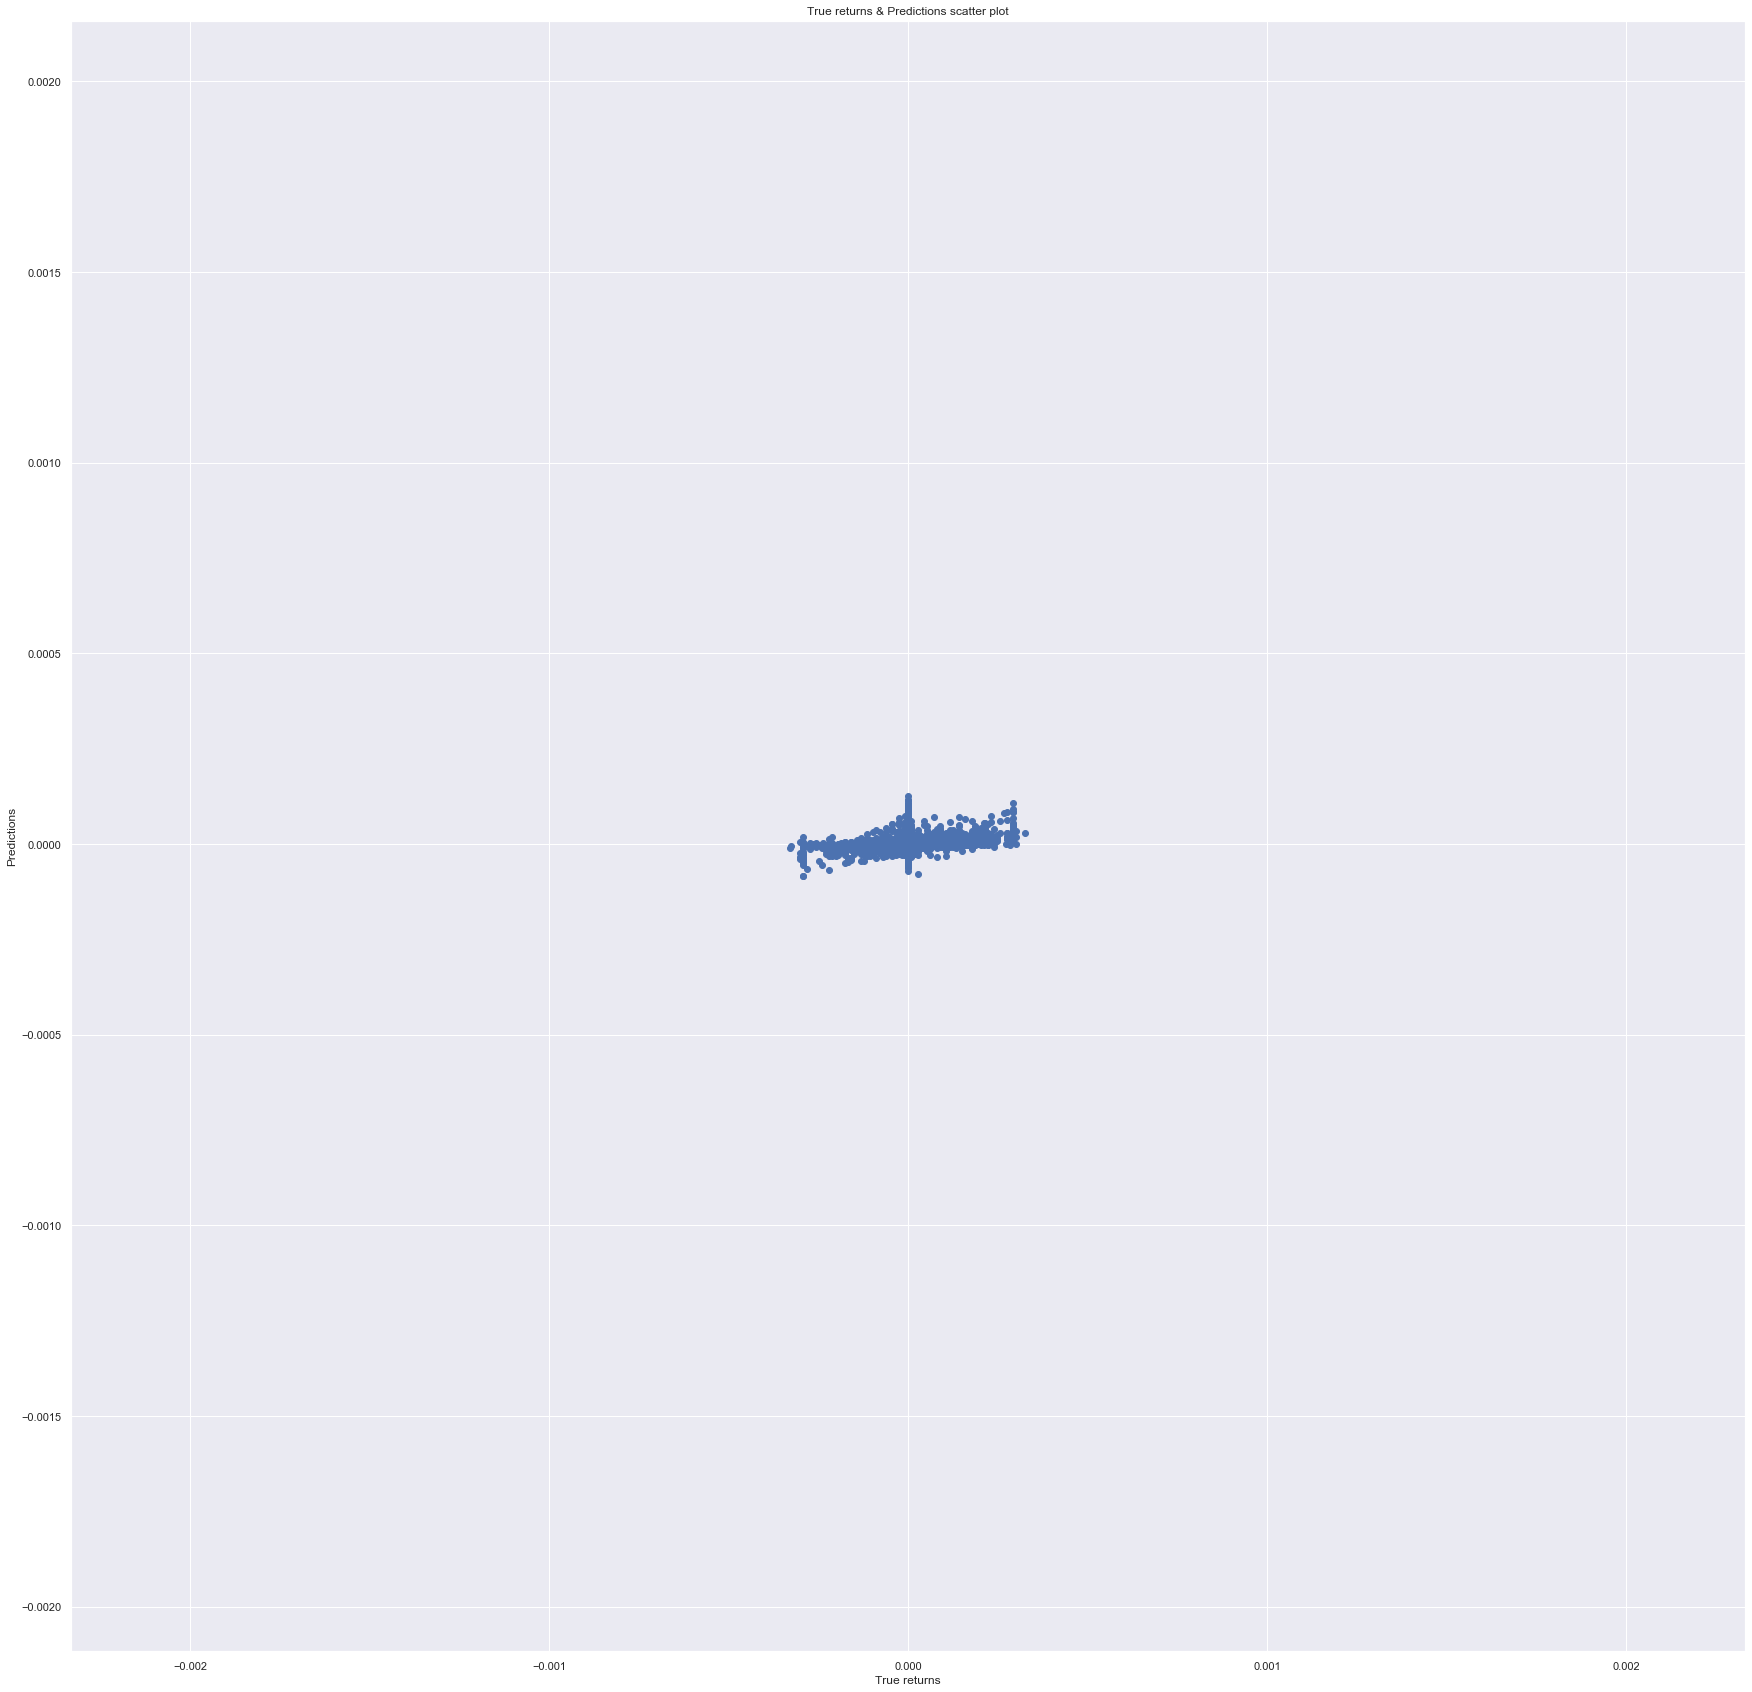

In [11]:
run_experiment('GOOG')

{'asset_name': 'MSFT', 'depth': 8.0, 'l2_leaf_reg': 6.375518633702504, 'learning_rate': 0.820242773021529, 'level': 5, 'n_estimators': 160.0, 'num_lags': 4.0}
Objective function value on validation set: 1.3051013101607414e-10
{'asset_name': 'MSFT', 'depth': 3.0, 'l2_leaf_reg': 18.570831106598128, 'learning_rate': 0.16893633551130577, 'level': 10, 'n_estimators': 125.0, 'num_lags': 5.0}
Objective function value on validation set: 1.2229850760533003e-10                  
{'asset_name': 'MSFT', 'depth': 6.0, 'l2_leaf_reg': 16.005277983088614, 'learning_rate': 0.3643657415946367, 'level': 5, 'n_estimators': 235.0, 'num_lags': 4.0}
Objective function value on validation set: 1.2970046970257478e-10                  
{'asset_name': 'MSFT', 'depth': 2.0, 'l2_leaf_reg': 8.096031755725166, 'learning_rate': 0.2046503426057844, 'level': 10, 'n_estimators': 295.0, 'num_lags': 5.0}
Objective function value on validation set: 1.1735140880090902e-10                  
{'asset_name': 'MSFT', 'depth': 5.

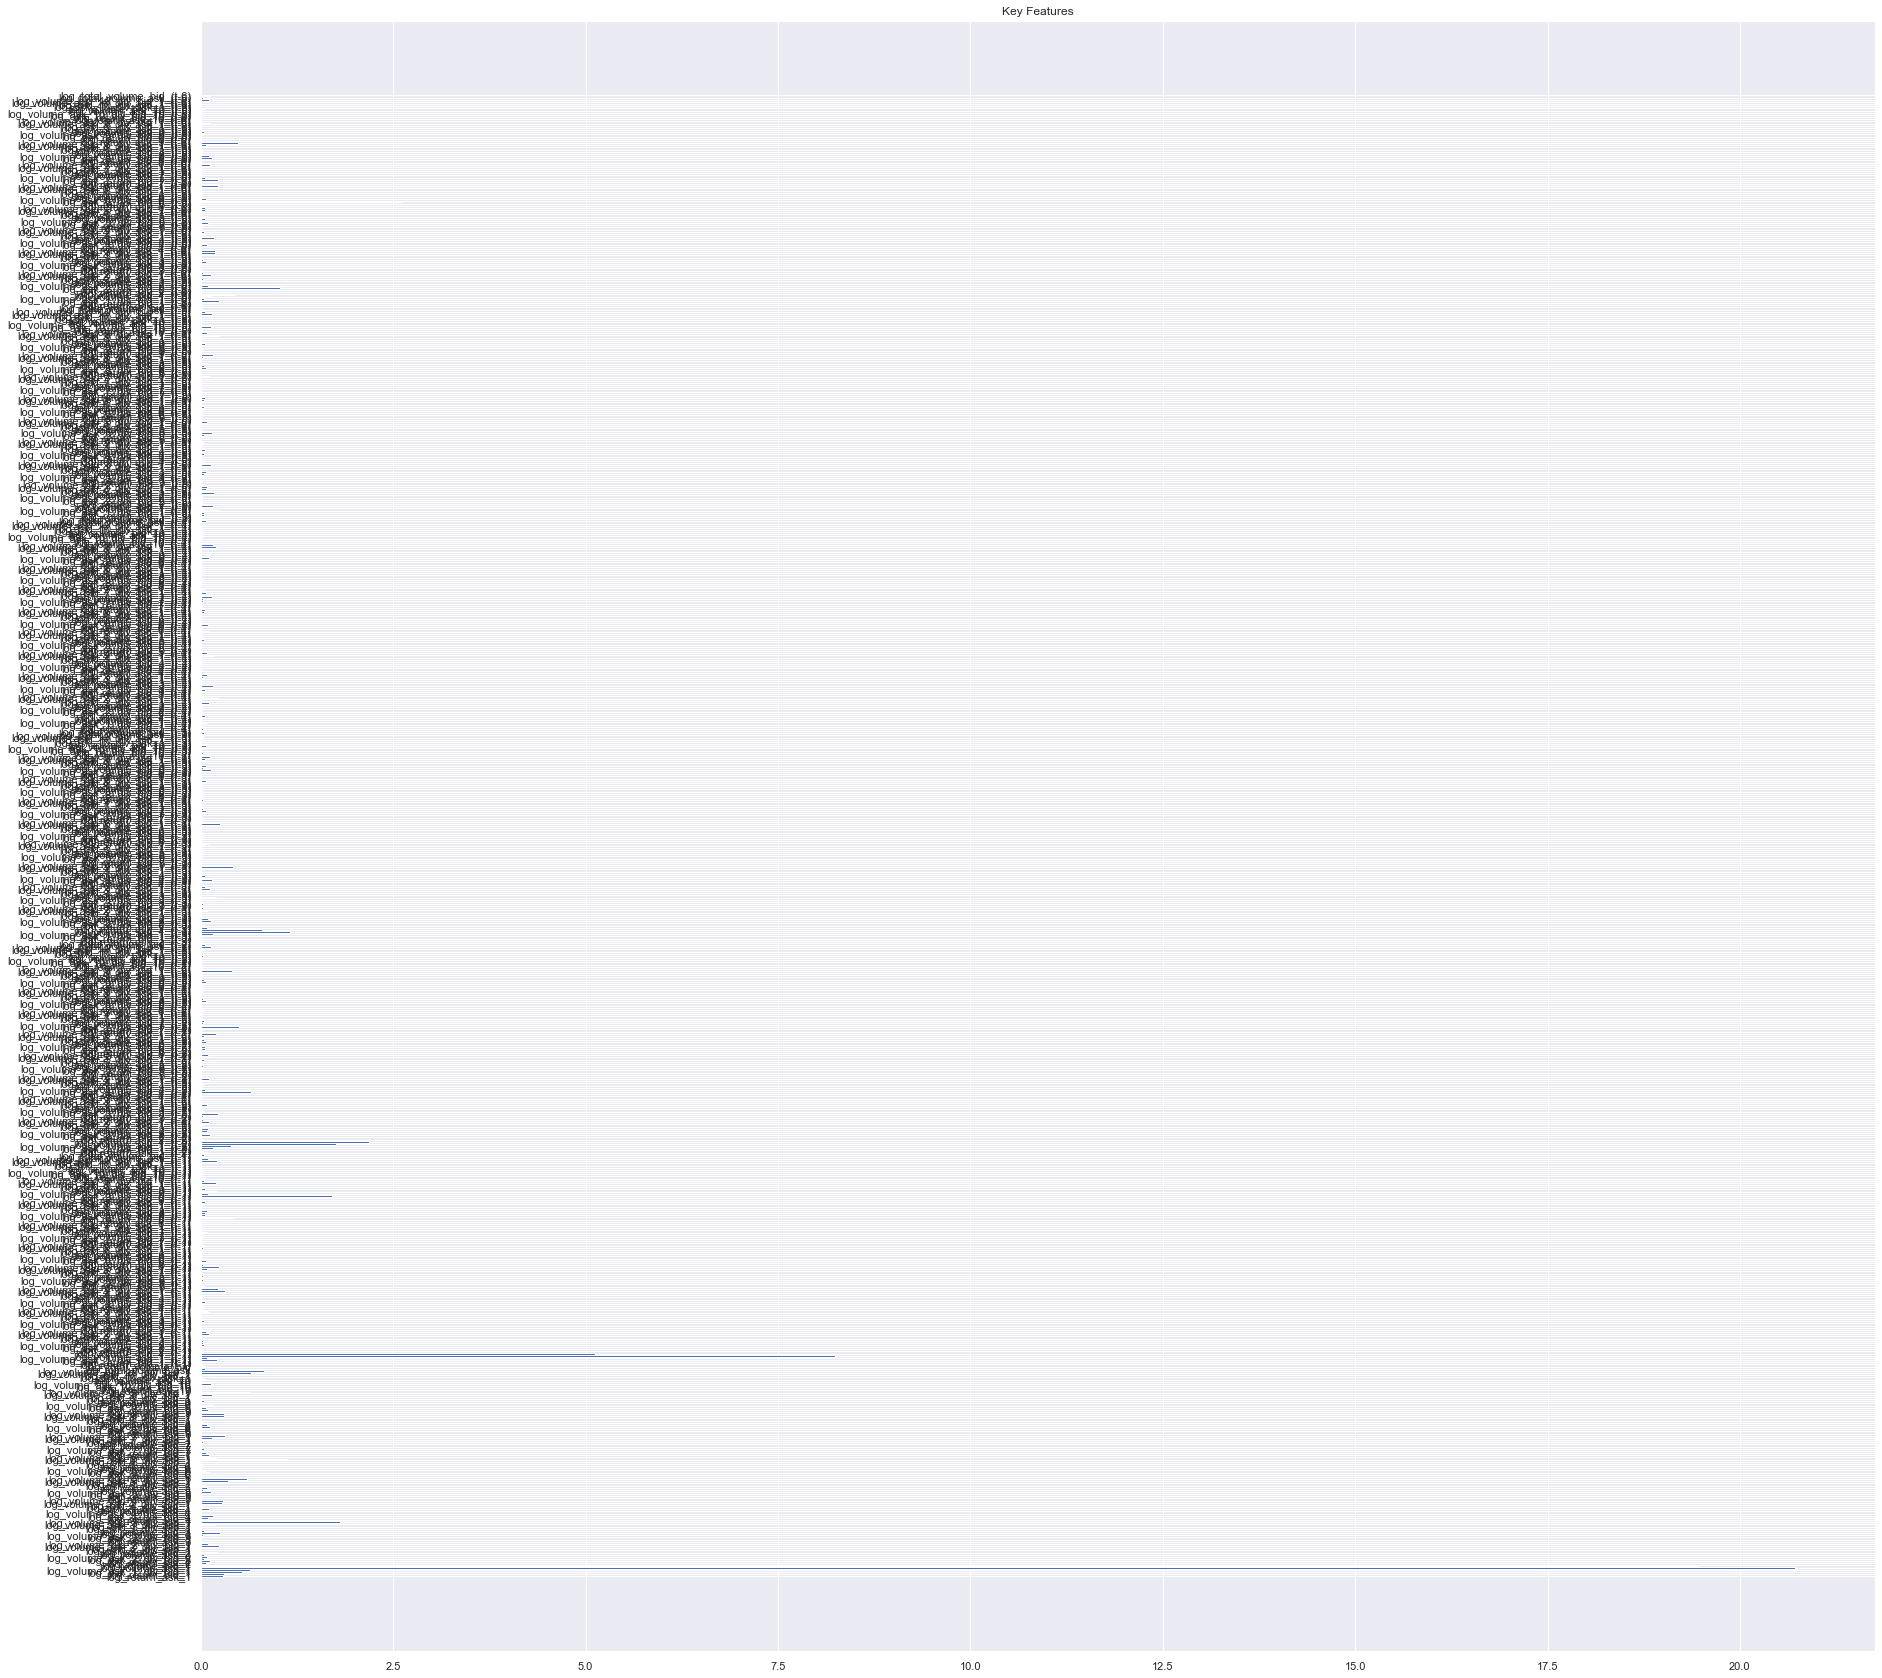

Key Features Table:
                       feature  importance
4             log_volume_ask_1   20.716997
5             log_volume_bid_1   19.459454
102     log_volume_ask_1_(t-1)    8.246943
103     log_volume_bid_1_(t-1)    5.124278
636  log_ask_6_div_bid_6_(t-6)    2.608805
..                         ...         ...
531     log_volume_bid_5_(t-5)    0.000000
532  log_ask_5_div_ask_1_(t-5)    0.000000
533  log_bid_5_div_bid_1_(t-5)    0.000000
171  log_bid_8_div_bid_1_(t-1)    0.000000
68         log_ask_8_div_bid_8    0.000000

[686 rows x 2 columns]
MSE on test set: 1.6137031444648976e-10
Confidence interval of baseline MSE: (1.279129142211921e-10, 1.3025586614258932e-10)
Confidence interval of modeling MSE: (1.597144425012727e-10, 1.6162202021011839e-10)


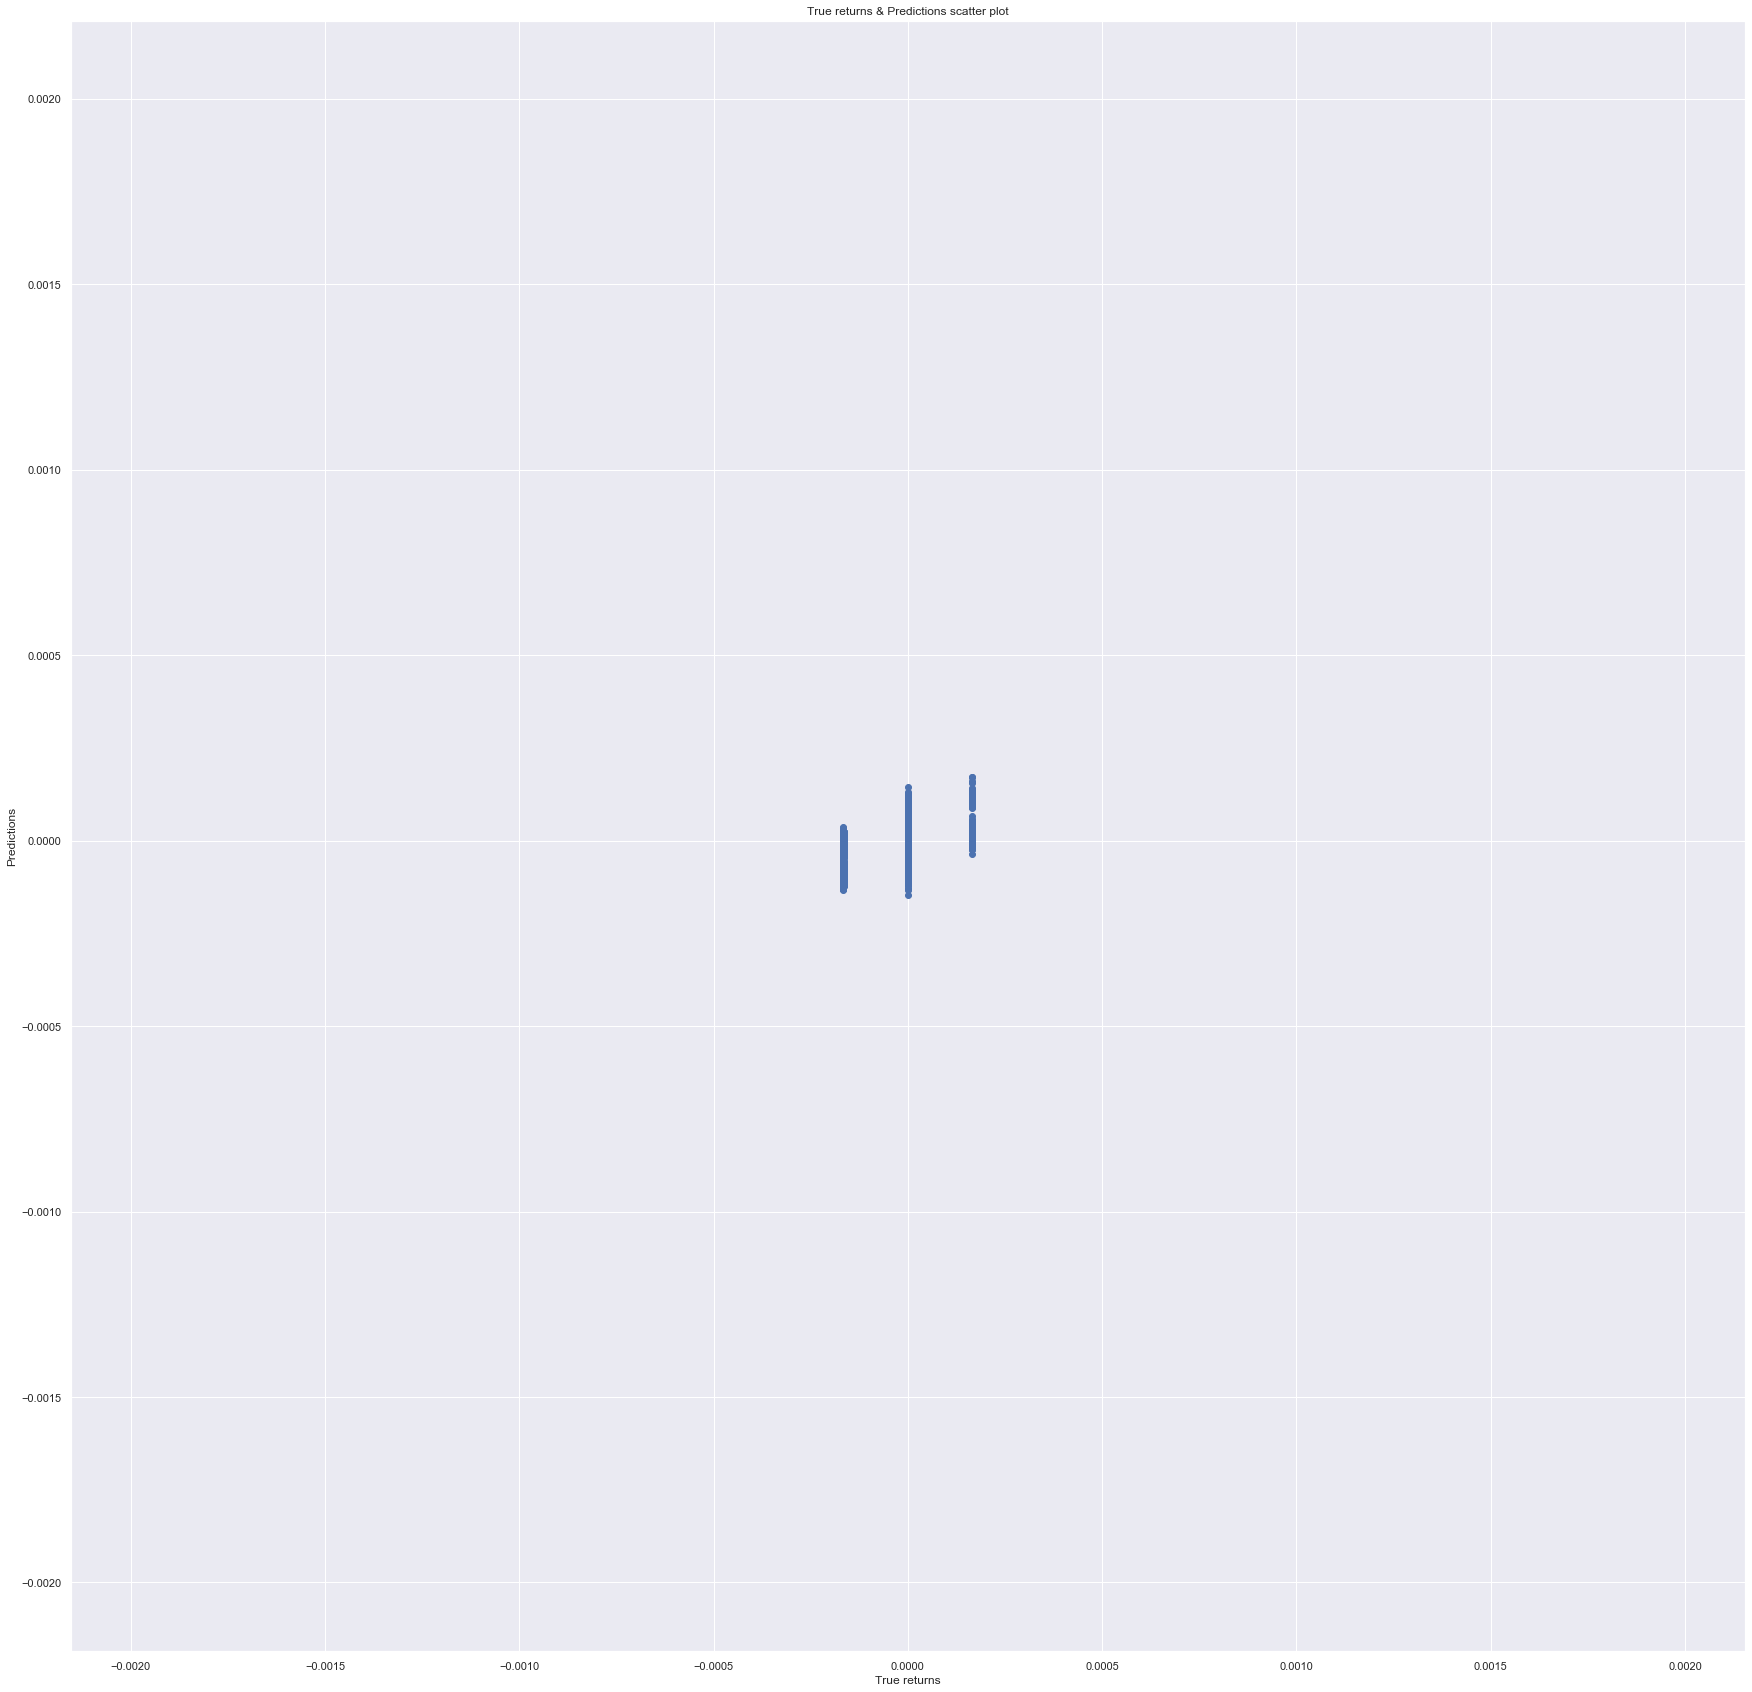

In [12]:
run_experiment('MSFT')